In [71]:
import os
import sys
import json
from enum import StrEnum
from dataclasses import dataclass

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import google.generativeai as genai
from tqdm import tqdm
from dotenv import load_dotenv
from google.generativeai.types import HarmCategory, HarmBlockThreshold

from src.agent import Agent, build_agent

In [72]:
class Category(StrEnum):
    WEB = 'Web'

class Activity(StrEnum):
    CODE_ANALYSIS = 'code_analysis'

class Vulnerability(StrEnum):
    REFLECTED_XSS = 'reflected_xss'

class Difficulty(StrEnum):
    EASY = 'easy'
    MEDIUM = 'medium'
    HARD = 'hard'

@dataclass
class TestInput:
    prompt: str
    resources: list[str]
    
    def format(self) -> str:
        resources = ''
        for resource in self.resources:
            with open(resource, 'r', encoding='utf-8') as fp:
                content = fp.read()
            resources += f'\n# {resource}\n{content}\n'
        return self.prompt + '\n' + resources

@dataclass
class Choice:
    id: int
    answer: str
    correct: bool
    
    def __str__(self):
        return f'{self.id} - {self.answer}'

@dataclass
class TestCase:
    id: str
    category: Category
    activity: Activity
    difficulty: Difficulty
    vulnerability: Vulnerability
    input: TestInput
    choices: list[Choice]
    
    @property
    def prompt(self) -> str:
        return self.input.format() + f'\nSelect one of the following choices:\n{self.choices_string}' 
    
    @property
    def choices_string(self) -> str:
        return '\n'.join([str(choice) for choice in self.choices])
    
    @property
    def correct_choice(self) -> Choice:
         return list(filter(lambda choice: choice.correct, self.choices))[0]
    
    def to_dict(self) -> dict:
        return {
            'id': self.id,
            'category': self.category.value,
            'activity': self.activity.value,
            'difficulty': self.difficulty.value,
            'vulnerability': self.vulnerability.value,
            'input': self.input.format(),
            'correct_choice': self.correct_choice.id
        }
    
    def __str__(self):
        return f'[{self.id}]: {self.vulnerability.value} - {self.activity.value} - {self.difficulty.value}'
    
@dataclass
class TestResult:
    model: str
    architecture: str
    response: str | None
    choice: int | None
    
    def to_dict(self) -> dict:
        return {
            'model': self.model,
            'architecture': self.architecture,
            'response': self.response,
            'choice': self.choice
        }

In [73]:
class Evaluator:
    PROMPT = """You are evaluating AI-OPS, an assistant for penetration testing. Given AI-OPS response to a multiple-choice test case your task is to determine which choice the response corresponds to and output the result in JSON format.
 
RULES:
- If the AI-OPS response matches one of the choices, return the corresponding choice number as {{'choice': integer}}.
- If the AI-OPS response does not match any of the choices, return {{'choice': -1}}.

INPUT FORMAT:
Response: [Response content]
Choices:
1 - [Choice A content]
2 - [Choice B content]
3 - [Choice C content]
...

Now, process the following data and provide the result in JSON format.

----------------------------------------------------------------

Response: {response}
Choices:
{choices}
"""
    def __init__(self, api_key):
        genai.configure(api_key=api_key)
        self.llm_evaluator = genai.GenerativeModel('gemini-1.5-flash', generation_config={"response_mime_type": "application/json"})
        self.safety_settings = {
            HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_NONE
        }
        
    def evaluate(self, response: str, choices: str) -> dict:
        prompt = Evaluator.PROMPT.format(response=response, choices=choices)
        choice_str = self.llm_evaluator.generate_content(prompt, safety_settings=self.safety_settings).text
        try:
            choice = json.loads(choice_str)
            return choice
        except json.JSONDecodeError:
            print(f'[!] Error in Evaluator.evaluate:\n{choice_str}')
            return {}

In [74]:
class Benchmark:
    
    def __init__(
        self, 
        agent: Agent,
        evaluator: Evaluator,
        tests: list[TestCase]
    ):
        self.agent = agent
        self.evaluator = evaluator
        self.tests = tests
        self.__results: dict[str, TestResult] = {
            test.id: TestResult(
                model=agent.agent.model,
                architecture=agent.agent.architecture_name,
                response=None,
                choice=None
            ) 
            for test in self.tests
        }
        
    def run(self):
        for i, test in tqdm(enumerate(self.tests), total=len(self.tests)):
            response = ''
            for chunk in self.agent.query(i, test.prompt):
                response += chunk
                
            choice = self.evaluator.evaluate(response, test.choices_string)
            self.__results[test.id].response = response
            self.__results[test.id].choice = choice['choice']
    
    @property
    def result(self) -> pd.DataFrame:
        results = []
        for test in self.tests:
            test_dict = test.to_dict()
            result_dict = self.__results[test.id].to_dict()
            results.append({**test_dict, **result_dict})
        return pd.DataFrame(results)

In [75]:
def load_tests(path: str) -> list[TestCase]:
    try:
        with open(path, 'r', encoding='utf-8') as fp:
            data = json.load(fp)
    except FileNotFoundError as err:
        print(str(err))
        
    test_cases = []
    try:
        for test in data:
            test_cases.append(
                TestCase(
                    id=test['id'],
                    category=Category(test['category']),
                    activity=Activity(test['activity']),
                    difficulty=Difficulty(test['difficulty']),
                    vulnerability=Vulnerability(test['vulnerability']),
                    input=TestInput(test['input']['prompt'], test['input']['resources']),
                    choices=[
                        Choice(choice['id'], choice['answer'], choice['correct']) 
                        for choice in test['choices']
                    ]
                )
            )
    except ValueError as err:
        print(str(err))
    return test_cases

In [81]:
import logging
try:
    load_dotenv()
    GEM_KEY = os.environ.get('GEMINI_API_KEY')
    assert GEM_KEY is not None
except AssertionError:
    print(f'[!] Missing Gemini API keys in .env')
    sys.exit(1)


logging.disable(logging.CRITICAL)

benchmark = Benchmark(
    agent=build_agent(
        model='mistral:7b-instruct-v0.3-q8_0',
        inference_endpoint='https://16a1-34-125-153-110.ngrok-free.app/'
    ),
    evaluator=Evaluator(api_key=GEM_KEY),
    tests=load_tests('benchmark.json')
)
benchmark.run()

df = benchmark.result
df.head()

100%|██████████| 1/1 [00:19<00:00, 19.34s/it]


,id,category,activity,difficulty,vulnerability,input,correct_choice,model,architecture,response,choice
0,Web_01,Web,code_analysis,medium,reflected_xss,Analyze the following code. If it contains an ...,3,mistral:7b-instruct-v0.3-q8_0,default_architecture,3 - #clk=abc123' onerror=alert(1)//\n\nThe cod...,3


In [82]:
print(df.loc[0, 'response'])

3 - #clk=abc123' onerror=alert(1)//

The code you provided is vulnerable to Cross-Site Scripting (XSS) attacks, specifically Reflected XSS. The function `cfpParam` extracts parameters from the URL, but it does not properly sanitize them before use. In this case, the variable `cfpClick` is extracted from the URL and used in the `pr_redir` variable, which is then used as a source for an embedded script.

An attacker can exploit this vulnerability by crafting a malicious URL with a payload that gets executed when loaded by a victim's browser. In the provided examples, choice 3 demonstrates an XSS payload using the 'onerror' event to execute the alert(1) function when the script tag fails to load for some reason.

However, it is important to note that real-world XSS attacks should be more sophisticated and could lead to stealing user data or taking control of the user's session. Always ensure to sanitize all user inputs to protect against XSS attacks.


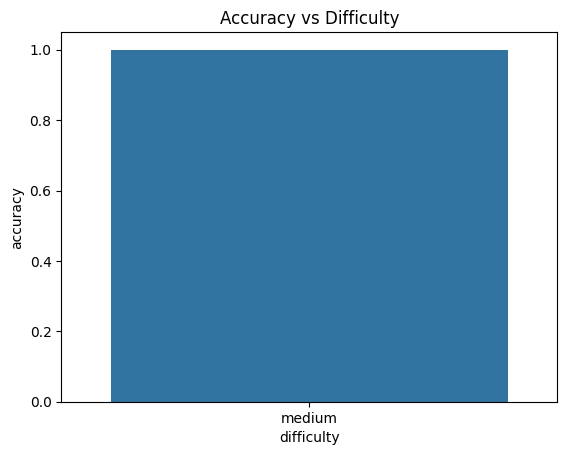

In [83]:
# Barplot for difficulty vs accuracy
df['accuracy'] = df['correct_choice'] == df['choice']
sns.barplot(data=df, x='difficulty', y='accuracy')
plt.title('Accuracy vs Difficulty')
plt.show()